In [1]:
import numpy as np
import matplotlib.pyplot as plt
import batman
import emcee as mc
import corner
from astropy.io import fits
from multiprocessing import Pool

import warnings
warnings.filterwarnings('ignore')

In [48]:
# Load in HST data
orbit1data = np.loadtxt('/home/matthew/data/hd219666b/reduced_data/broadband_lightcurve.dat', unpack=True,
                       skiprows=2, max_rows=20-2)
orbit2data = np.loadtxt('/home/matthew/data/hd219666b/reduced_data/broadband_lightcurve.dat', unpack=True,
                       skiprows=20, max_rows=38-20)
orbit3data = np.loadtxt('/home/matthew/data/hd219666b/reduced_data/broadband_lightcurve.dat', unpack=True,
                       skiprows=38, max_rows=56-38)
orbit4data = np.loadtxt('/home/matthew/data/hd219666b/reduced_data/broadband_lightcurve.dat', unpack=True,
                       skiprows=56)
# Keep track of lengths of arrays so that I can differentiate between orbits
#   once they're all concatenated
orbit1end = len(orbit1data[0])
orbit2end = len(orbit2data[0])
orbit3end = len(orbit3data[0])
orbit4end = len(orbit4data[0])

# cutting out a known outlier in orbit 2
outlier_idx = np.where(orbit2data[1] < 0.995)[0]
orbit2data = np.delete(orbit2data, outlier_idx, axis=1)

skip_first = True # flag to skip the first orbit's data
if skip_first:
    time = np.concatenate((orbit2data[0], orbit3data[0], orbit4data[0]))
    flux = np.concatenate((orbit2data[1], orbit3data[1], orbit4data[1]))
    uncy = np.concatenate((orbit2data[2], orbit3data[2], orbit4data[2]))
    orbit_seps = np.asarray([orbit2end, orbit3end+orbit2end, orbit4end+orbit3end+orbit2end])
elif not skip_first:
    time = np.concatenate((orbit1data[0], orbit2data[0], orbit3data[0], orbit4data[0]))
    flux = np.concatenate((orbit1data[1], orbit2data[1], orbit3data[1], orbit4data[1]))
    uncy = np.concatenate((orbit1data[2], orbit2data[2], orbit3data[2], orbit4data[2]))
    orbit_seps = np.asarray([orbit1end, orbit2end+orbit1end, orbit3end+orbit2end+orbit1end, 
                             orbit4end+orbit3end+orbit2end+orbit1end])
    
del orbit1data, orbit2data, orbit3data, orbit4data

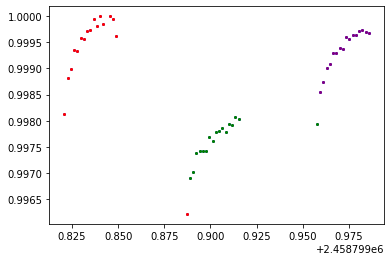

In [49]:
plt.scatter(time, flux, c='blue', s=3)
plt.scatter(time[:orbit_seps[0]], flux[:orbit_seps[0]], s=4, c='red')
plt.scatter(time[orbit_seps[0]:orbit_seps[1]], flux[orbit_seps[0]:orbit_seps[1]], s=4, c='green')
plt.scatter(time[orbit_seps[1]:orbit_seps[2]], flux[orbit_seps[1]:orbit_seps[2]], s=4, c='purple')
plt.show()

In [50]:
##
# Defining my parameter arrays (inits, priors, etc)
#
# General Structure:
# 0 = tc
# 1 = log10P
# 2 = log10(a/Rstar)
# 3 = cos(i)
# 4 = Rp / Rstar
# 5 = hook model amplitude
# 6 = hook model time-scale

labels = np.asarray(['tc', 'log10P', 'log10a', 'cosi', 'RpRs', 'amp', 'tau'])

theta_init = np.asarray([2458329.200812692, 0.7806389638593276, 1.1236846042500,
                        0.063275337435110, 0.0410051351478540,
                        0.00147864969441, 0.0049631992291])

# Priors
lit_tc = 2458329.1996  # [day; bjd tdb]
lit_P = 6.034460       # [day]
lit_rprs = 0.04192       # [Rstar]
lit_a = 13.27          # [Rstar]
lit_i = 86.38          # [degrees]
lit_Rp = 4.71          # [Rearth]

lit_e = 0.
lit_w = 90.*(np.pi/180.)  # [radian]

priors = np.asarray([
    # Shared orbital parameters 
    lit_tc,                      # 0 - conjunction time
    np.log10(lit_P),             # 1 - log10 Period
    np.log10(lit_a),             # 2 - log10 semi-major axis
    np.cos(lit_i*(np.pi/180.)),  # 3 - cosine inclination
    # Planetary parameters
    np.inf,                      # 4 - HST radius
    # HST systematic parameters
    np.inf,                      # 7 - orbit 3&4 hook amplitude
    np.inf                       # 8 - orbit 3&4 hook timescale
])
# set those which shouldn't have a prior to have value of infinity

c = 1. / np.log(10.)
priorserr = np.asarray([
    # Shared orbital parameters 
    0.0012,                                          # 0 - conjunction time
    ((c*0.000011)/lit_P),                            # 1 - log10 Period
    ((c*0.39)/lit_a),                                # 2 - log10 semi-major axis
    np.sin(lit_i*(np.pi/180.))*(0.15*(np.pi/180.)),  # 3 - cosine inclination
    # Planetary parameters
    0.00083,                                         # 4 - HST radius
    # HST systematic parameters
    1.e-3,                                            # 7 - orbit 3&4 hook amplitude
    1.e-3                                             # 8 - orbit 3&4 hook timescale
])

# Initializing the BATMAN model
InitParams = batman.TransitParams()
InitParams.t0 = theta_init[0]      
InitParams.per = 10.**theta_init[1]
InitParams.a = 10.**theta_init[2]
InitParams.inc = np.arccos(theta_init[3])*(180./np.pi)
InitParams.rp = theta_init[4]
InitParams.ecc = 0.
InitParams.w = 90.
InitParams.limb_dark = 'quadratic'
InitParams.u = [0.33, 0.2]
BATMAN_initmodel = batman.TransitModel(InitParams, time)

In [51]:
##
# Defining my astrophysical models

def transit(theta, initmodel, telescope='hst'):
    # Transit Light curve model
    # Inputs:
    # theta = array of lightcurve parameters
    # initmodel = initialized BATMAN model environment, allows
    #    single function to compute both HST and TESS transit light curves
    # telescope = tells me which telescope (i.e. which filter) so I know which radius parameter to use
    
    # Unpack input parameters
    tc = theta[0]       # time of conjunction [days]
    log10P = theta[1]   # log10( Period [days] )
    log10a = theta[2]   # log10( a / Rstar )
    cosi = theta[3]     # cosine(inclination [rad])
    #sqrtecosw = theta[4]
    #sqrtesinw = theta[5]
    
    if (telescope == 'hst'):
        rprstar = theta[4]
    elif (telescope == 'tess'):
        print('Not yet set up to use TESS!')
        #rprstar = theta[7]
    else:
        print('Input a correct telescope name')
        
    # Transform input parameters to forms used by BATMAN
    P = 10.**(log10P)  # compute Period in [day]
    a = 10.**(log10a)  # compute a/Rstar
    inc = np.arccos(cosi)*(180./np.pi)  # Compute inclination in [deg]
    #ecc = sqrtecosw**2 + sqrtesinw**2
    #omega = np.arctan2(sqrtesinw, sqrtecosw)*(180./np.pi)  # [degrees]
    ecc = 0.    # use these if assuming circular orbit
    omega = 90.
    
    # Initialize batman parameters
    params = batman.TransitParams()
    params.t0 = tc             # transit midpoint [day]
    params.per = P    # log10 (period [day])
    params.rp = rprstar
    params.a = a      # log10 (semi major axis [Rstar])
    params.inc = inc  # cosine inclination [degrees]
    
    params.ecc = ecc
    params.w = omega
    
    # Using Esposito's quadratic limb darkening treatment
    params.limb_dark = 'quadratic'
    params.u = [0.33, 0.2]
    
    lightcurve = initmodel.light_curve(params)
    return lightcurve


##
# Defining my systematic models
def hook(theta):
    # Orbit-long charge trapping hook model for HST
    # Inputs:
    # theta = array of lightcurve parameters
    # torbit = time since start of corresponding orbit in units [day]
    
    amplitude = theta[5]  # hook model amplitude [normalized units]
    tau = theta[6]        # hook model time-scale [day]
    
#     hookamp2 = theta[7]
#     hooktau2 = theta[8]
    
    # Pull out times [in day; MJD] of each orbit
    orbit2times = time[:orbit_seps[0]]
    orbit3times = time[orbit_seps[0] : orbit_seps[1]]
    orbit4times = time[orbit_seps[1] : orbit_seps[2]]
    
    # From above, compute time since beginning of orbit for each
    tinorbit2 = orbit2times - orbit2times[0]
    tinorbit3 = orbit3times - orbit3times[0]
    tinorbit4 = orbit4times - orbit4times[0]
    
    orbit2hook = 1.0 - amplitude*np.exp(- tinorbit2 / tau)
    orbit3hook = 1.0 - amplitude*np.exp(- tinorbit3 / tau)
    orbit4hook = 1.0 - amplitude*np.exp(- tinorbit4 / tau)
    
    hookcurve = np.concatenate((orbit2hook, orbit3hook, orbit4hook)) 
    return hookcurve

In [52]:
def logLikelihood(ydata, yerr, modely):
    
    likelihoodarray = -0.5*((ydata-modely)**2/(yerr**2)) - np.log(np.sqrt(2.*np.pi*yerr*yerr))
    lnL = np.sum(likelihoodarray)
    
    return lnL

def logPriors(theta, priors, priorserr):
    
    # Limits on certain parameters
    
    lnP = 0.
    for i, priorval in enumerate(priors):
        if np.isinf(priorval):
            continue
        else:
            lnP += -0.5*((priorval-theta[i])**2/(priorserr[i]**2)) - np.log(np.sqrt(2.*np.pi*priorserr[i]*priorserr[i]))
    
    return lnP

def lnPosterior(theta):
    
    prior_array = priors
    priorerrs_array = priorserr
    flux_array = flux
    unc_array = uncy
    
    
    # Compute and check priors
    lnPrior_value = logPriors(theta, prior_array, priorerrs_array)
    if not np.isfinite(lnPrior_value):
        return -np.inf
    
    # Compute models
    HSTtransit = transit(theta, BATMAN_initmodel)
    HSThook = hook(theta)
    model = HSTtransit * HSThook

    # Compute likelihoods
    lnLikelihood = logLikelihood(flux_array, unc_array, model)

    # Compute posterior
    lnPost = lnPrior_value + lnLikelihood
    
    if np.isnan(lnPost):
        return -np.inf
    else:
        return lnPost

-215687645980.25183


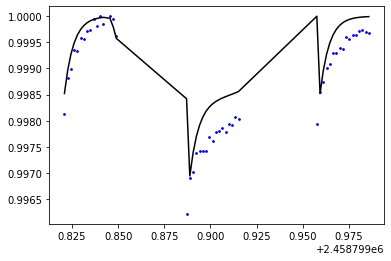

In [53]:
transit_model = transit(theta_init, BATMAN_initmodel)
hook_model = hook(theta_init)
model = transit_model * hook_model

lnPost_init = lnPosterior(theta_init)
print(lnPost_init)
plt.scatter(time, flux, c='blue', s=3)
plt.plot(time, model, c='black')
plt.show()

In [54]:
######################################
# Setting up and initializing MCMC

Ndimensions = len(theta_init)
Nwalkers = 3*Ndimensions
Nsteps = 10000

# Initializing walker positions
pos = np.zeros((Nwalkers, Ndimensions))

for i in range(Ndimensions):
    pos[:,i] = theta_init[i] + 0.5*np.random.normal(0., priorserr[i], Nwalkers)
    


In [55]:
with Pool() as pool: 
    sampler = mc.EnsembleSampler(Nwalkers, Ndimensions, lnPosterior, pool=pool)
    sampler.run_mcmc(pos, Nsteps, progress=True);

100%|██████████| 10000/10000 [01:39<00:00, 100.49it/s]


In [60]:
samples = sampler.get_chain()
flatsamples = sampler.get_chain(flat=True)
loglikelihoods = sampler.get_log_prob(flat=True)
#autocorrtimes = sampler.get_autocorr_time()

burn = 8400
samples = samples[burn:]
flatsamples = flatsamples[burn*Nwalkers:]
loglikelihoods = loglikelihoods[burn*Nwalkers:]

Text(0.5, 0, 'Steps')

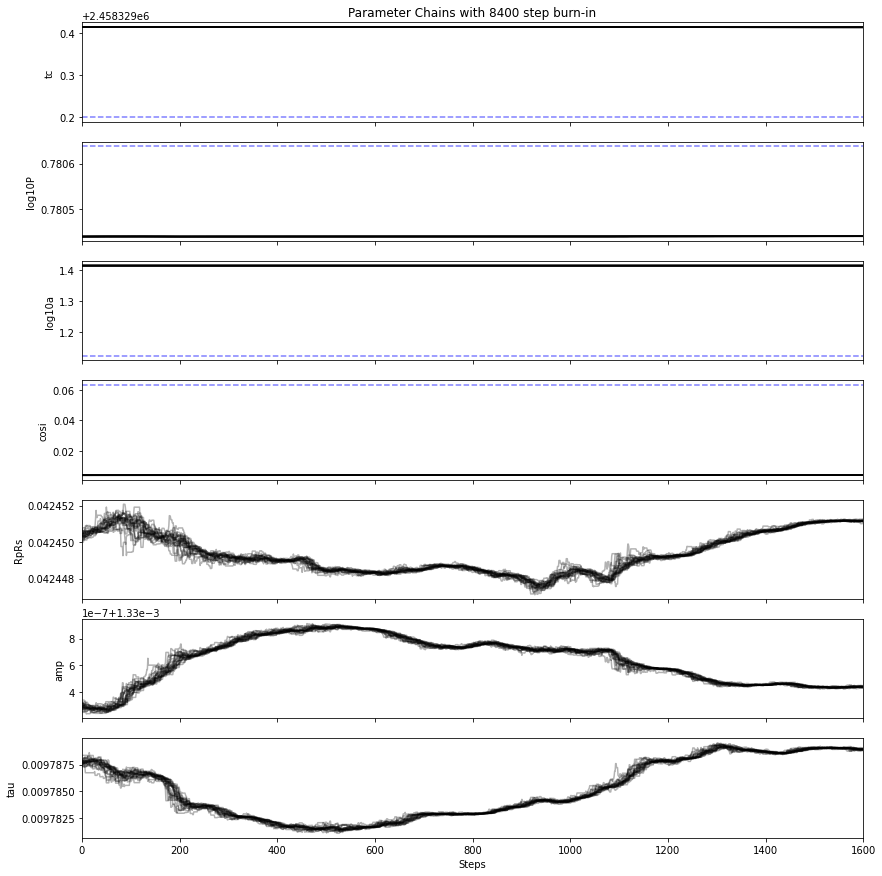

In [61]:
fig, axes = plt.subplots(samples.shape[2], figsize=(14,15), sharex=True)
for i in range(samples.shape[2]):
    ax = axes[i]
    ax.plot(samples[:,:,i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.axhline(priors[i], c='blue', ls='--', alpha=0.5)
axes[0].set_title('Parameter Chains with %d step burn-in'%burn)
axes[-1].set_xlabel('Steps')

In [62]:
param_fits = np.asarray([np.median(flatsamples[:,i]) for i in range(samples.shape[2])])
param_uperrs = np.asarray([np.percentile(flatsamples[:,i], 84) for i in range(samples.shape[2])]) - param_fits
param_loerrs = param_fits - np.asarray([np.percentile(flatsamples[:,i], 16) for i in range(samples.shape[2])])

bf_transit = transit(param_fits, BATMAN_initmodel)
bf_hook = hook(param_fits)
bf_model = bf_transit * bf_hook

init =  -215687645980.25183
best fit =  -109042898942.08304
ratio =  0.5055593167912218


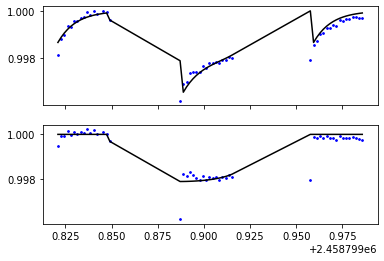

In [65]:
bf_lnPost = lnPosterior(param_fits)
print('init = ', lnPost_init)
print('best fit = ', bf_lnPost)
print('ratio = ', abs(bf_lnPost)/abs(lnPost_init))

fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].scatter(time, flux, c='blue', s=3)
ax[0].plot(time, bf_model, c='black')

detflux = flux / bf_hook
ax[1].plot(time, bf_transit, c='black')
ax[1].scatter(time, detflux, c='blue', s=3)
plt.show()